<a href="https://colab.research.google.com/github/Shaw2711/Machine-Learning---CT4101/blob/main/CT4101%2B_%2BAssignment%2B2%2BSai_Shasank_Dandu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("steel.csv")
df

,normalising_temperature,tempering_temperature,percent_silicon,percent_chromium,percent_copper,percent_nickel,percent_sulphur,percent_carbon,percent_manganese,tensile_strength
0,178.500,275,0.1530,0.970575,0.942,0.8870,0.0,1.920,0.0,25.107613
1,178.500,950,0.1530,1.212726,0.942,0.8870,0.0,1.920,0.0,140.035334
2,178.500,375,0.1530,1.621165,0.942,0.8870,0.0,1.920,0.0,42.217650
3,178.500,900,0.1530,0.809989,0.942,0.8870,0.0,1.920,0.0,95.015309
4,189.525,900,0.1624,1.036229,0.849,0.9382,0.0,2.035,0.0,113.266773
...,...,...,...,...,...,...,...,...,...,...
548,945.000,900,0.0000,1.735469,0.613,1.1250,0.0,1.730,0.0,370.186559
549,945.000,950,0.0000,1.394783,0.613,1.1250,0.0,1.730,0.0,383.117682
550,945.000,950,0.0000,1.685472,0.613,1.1250,0.0,1.730,0.0,393.925218
551,945.000,950,0.0000,1.353720,0.613,1.1250,0.0,1.730,0.0,407.918133


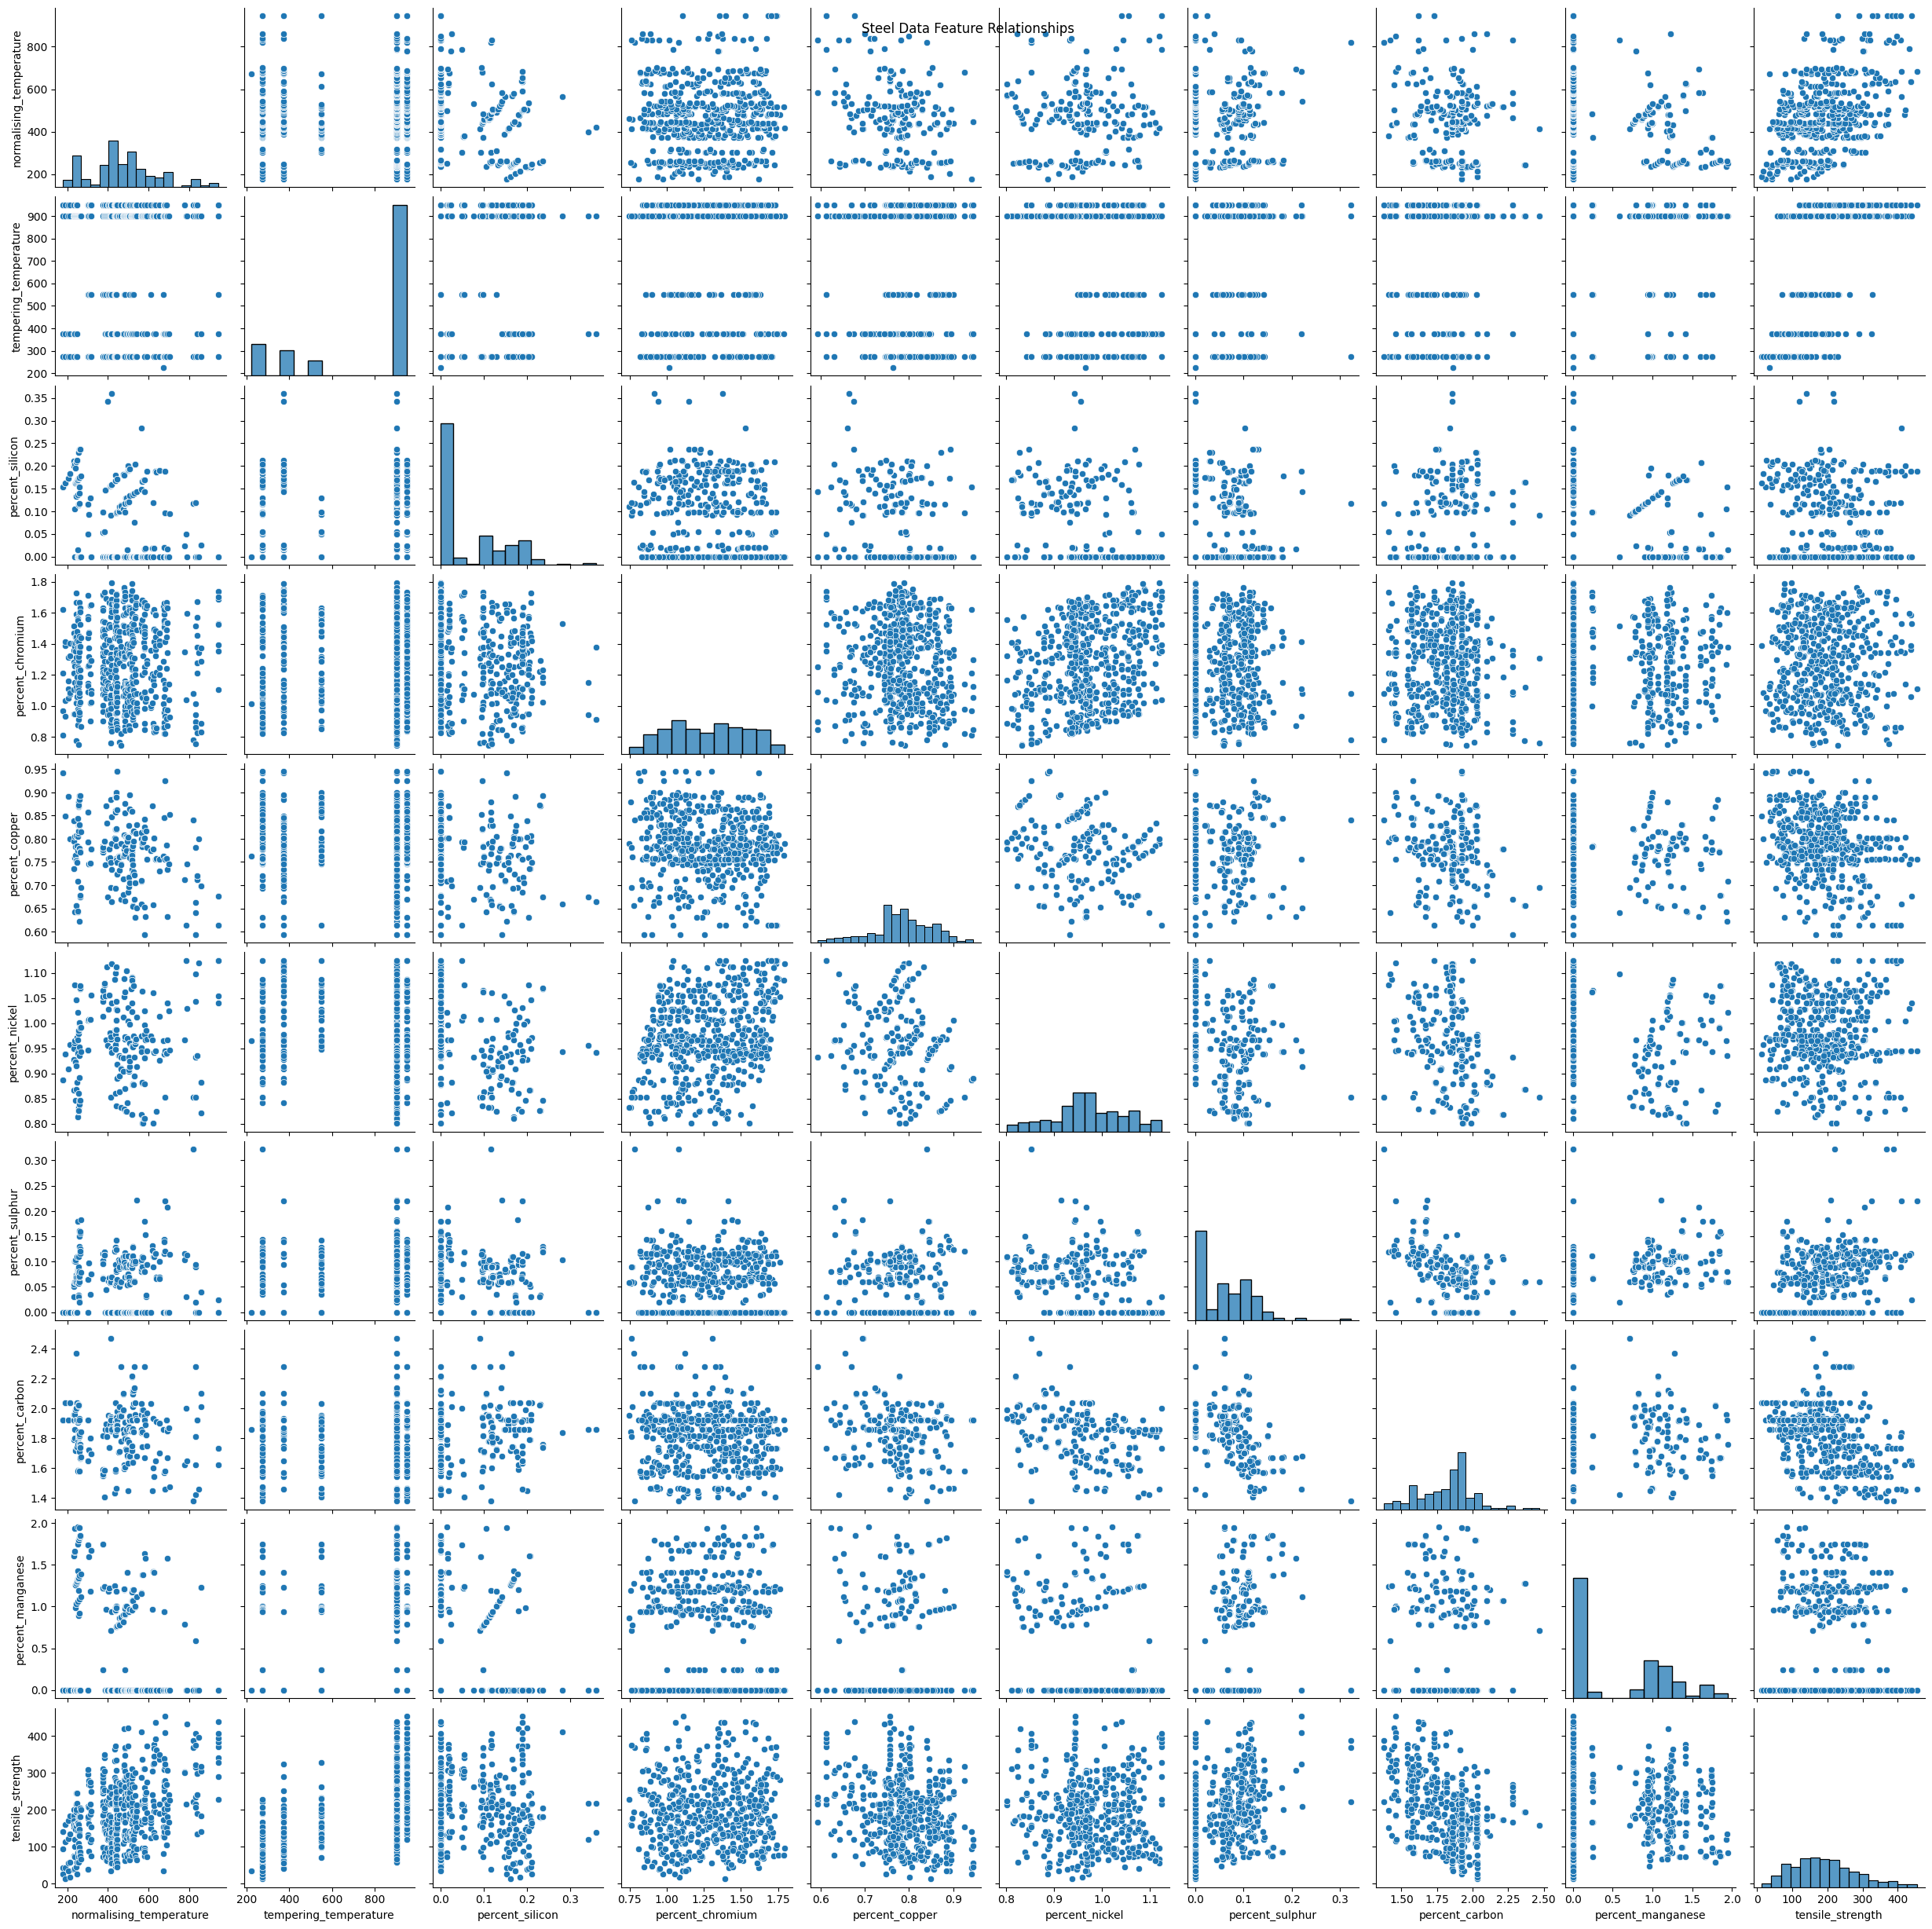

In [3]:
sns.pairplot(df)
plt.suptitle("Steel Data Feature Relationships")
plt.show()

In [4]:
feature_names = df.columns[:-1].tolist()
target_name = df.columns[-1]
print("Features:", feature_names)
print("Target:", target_name)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

Features: ['normalising_temperature', 'tempering_temperature', 'percent_silicon', 'percent_chromium', 'percent_copper', 'percent_nickel', 'percent_sulphur', 'percent_carbon', 'percent_manganese']
Target: tensile_strength


In [5]:
sns.pairplot(df.sample(min(200, len(df))), diag_kind="kde")  # sample if too big
plt.suptitle("EDA: Pairplot (sample of dataset)", y=1.02)
plt.tight_layout()
plt.savefig("fig_pairplot.png", dpi=200)
plt.close()


In [6]:
# Correlation heatmap - inspiration: seaborn heatmap examples
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.tight_layout()
plt.savefig("fig_correlation_heatmap.png", dpi=200)
plt.close()

In [7]:
# Distribution of target
plt.figure(figsize=(7,4))
sns.histplot(df[target_name], bins=20, kde=True)
plt.title("Distribution of " + target_name)
plt.xlabel(target_name)
plt.tight_layout()
plt.savefig("fig_target_distribution.png", dpi=200)
plt.close()

In [10]:
# MODELS & PARAM GRIDS
# ---------------------------
# Gradient Boosting defaults and grid (inspired by scikit-learn docs)
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
gbr_default = GradientBoostingRegressor(random_state=42)
gbr_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2]
}

# SVR Pipeline (scale then SVR). Pipeline pattern inspiration:
# https://scikit-learn.org/stable/modules/compose.html#pipeline
svr_pipeline_default = Pipeline([("scaler", StandardScaler()), ("svr", SVR())])
svr_param_grid = {
    "svr__C": [0.1, 1, 10, 100],
    "svr__kernel": ["rbf", "poly"],
    "svr__gamma": ["scale"]   # default and generally good - could add numeric values
}
# GridSearch pattern inspiration: GeeksforGeeks GridSearchCV tutorial
# https://www.geeksforgeeks.org/how-to-use-gridsearchcv-in-scikit-learn/

# ---------------------------
# OUTER CV SETUP: 10-FOLD
# ---------------------------
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Containers for aggregated (cross-validated) test predictions across outer folds
y_pred_gbr_default = np.zeros_like(y, dtype=float)
y_pred_gbr_tuned   = np.zeros_like(y, dtype=float)
y_pred_svr_default = np.zeros_like(y, dtype=float)
y_pred_svr_tuned   = np.zeros_like(y, dtype=float)

# Containers for per-fold metrics and best params
results = {
    "GradientBoosting": {"default_train": [], "default_test": [], "tuned_train": [], "tuned_test": [], "best_params": []},
    "SVR": {"default_train": [], "default_test": [], "tuned_train": [], "tuned_test": [], "best_params": []}
}

# ---------------------------
# OUTER CV LOOP
# ---------------------------
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    print(f"Outer fold {fold} / 10")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # ---------- GBR default ----------
    gbr = clone(gbr_default)
    gbr.fit(X_train, y_train)
    y_train_pred = gbr.predict(X_train)
    y_test_pred  = gbr.predict(X_test)
    # store aggregated predictions for this fold (for final aggregated visualisations)
    y_pred_gbr_default[test_idx] = y_test_pred

    # metrics
    results["GradientBoosting"]["default_train"].append((mean_squared_error(y_train, y_train_pred),
                                                        mean_absolute_percentage_error(y_train, y_train_pred)*100))
    results["GradientBoosting"]["default_test"].append((mean_squared_error(y_test, y_test_pred),
                                                       mean_absolute_percentage_error(y_test, y_test_pred)*100))

    # ---------- GBR tuned (inner GridSearchCV cv=5) ----------
    gbr_gs = GridSearchCV(GradientBoostingRegressor(random_state=42),
                          gbr_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, refit=True)
    gbr_gs.fit(X_train, y_train)
    best_gbr = gbr_gs.best_estimator_
    results["GradientBoosting"]["best_params"].append(gbr_gs.best_params_)
    # evaluate tuned
    y_train_pred_tuned = best_gbr.predict(X_train)
    y_test_pred_tuned  = best_gbr.predict(X_test)
    # store aggregated
    y_pred_gbr_tuned[test_idx] = y_test_pred_tuned

    results["GradientBoosting"]["tuned_train"].append((mean_squared_error(y_train, y_train_pred_tuned),
                                                      mean_absolute_percentage_error(y_train, y_train_pred_tuned)*100))
    results["GradientBoosting"]["tuned_test"].append((mean_squared_error(y_test, y_test_pred_tuned),
                                                     mean_absolute_percentage_error(y_test, y_test_pred_tuned)*100))

    # ---------- SVR default ----------
    svr_def = clone(svr_pipeline_default)
    svr_def.fit(X_train, y_train)
    y_train_pred = svr_def.predict(X_train)
    y_test_pred  = svr_def.predict(X_test)
    y_pred_svr_default[test_idx] = y_test_pred

    results["SVR"]["default_train"].append((mean_squared_error(y_train, y_train_pred),
                                           mean_absolute_percentage_error(y_train, y_train_pred)*100))
    results["SVR"]["default_test"].append((mean_squared_error(y_test, y_test_pred),
                                          mean_absolute_percentage_error(y_test, y_test_pred)*100))

    # ---------- SVR tuned ----------
    svr_gs = GridSearchCV(svr_pipeline_default, svr_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, refit=True)
    svr_gs.fit(X_train, y_train)
    best_svr = svr_gs.best_estimator_
    results["SVR"]["best_params"].append(svr_gs.best_params_)

    y_train_pred_tuned = best_svr.predict(X_train)
    y_test_pred_tuned  = best_svr.predict(X_test)
    y_pred_svr_tuned[test_idx] = y_test_pred_tuned

    results["SVR"]["tuned_train"].append((mean_squared_error(y_train, y_train_pred_tuned),
                                         mean_absolute_percentage_error(y_train, y_train_pred_tuned)*100))
    results["SVR"]["tuned_test"].append((mean_squared_error(y_test, y_test_pred_tuned),
                                        mean_absolute_percentage_error(y_test, y_test_pred_tuned)*100))

    print(f"  GBR best params (fold {fold}): {gbr_gs.best_params_}")
    print(f"  SVR best params (fold {fold}): {svr_gs.best_params_}")

Outer fold 1 / 10
  GBR best params (fold 1): {'learning_rate': 0.2, 'n_estimators': 50}
  SVR best params (fold 1): {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Outer fold 2 / 10
  GBR best params (fold 2): {'learning_rate': 0.1, 'n_estimators': 200}
  SVR best params (fold 2): {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Outer fold 3 / 10
  GBR best params (fold 3): {'learning_rate': 0.1, 'n_estimators': 50}
  SVR best params (fold 3): {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Outer fold 4 / 10
  GBR best params (fold 4): {'learning_rate': 0.1, 'n_estimators': 50}
  SVR best params (fold 4): {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Outer fold 5 / 10
  GBR best params (fold 5): {'learning_rate': 0.1, 'n_estimators': 100}
  SVR best params (fold 5): {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Outer fold 6 / 10
  GBR best params (fold 6): {'learning_rate': 0.2, 'n_estimators': 50}
  SVR best params (

In [11]:
def summarise_list(lst):
    arr = np.array(lst)
    mean = arr.mean(axis=0)
    std  = arr.std(axis=0)
    return mean, std

# Summaries
gbr_def_train_mean, gbr_def_train_std = summarise_list(results["GradientBoosting"]["default_train"])
gbr_def_test_mean,  gbr_def_test_std  = summarise_list(results["GradientBoosting"]["default_test"])
gbr_tun_train_mean, gbr_tun_train_std = summarise_list(results["GradientBoosting"]["tuned_train"])
gbr_tun_test_mean,  gbr_tun_test_std  = summarise_list(results["GradientBoosting"]["tuned_test"])

svr_def_train_mean, svr_def_train_std = summarise_list(results["SVR"]["default_train"])
svr_def_test_mean,  svr_def_test_std  = summarise_list(results["SVR"]["default_test"])
svr_tun_train_mean, svr_tun_train_std = summarise_list(results["SVR"]["tuned_train"])
svr_tun_test_mean,  svr_tun_test_std  = summarise_list(results["SVR"]["tuned_test"])

# Save numeric summary CSV for report (one row per model)
summary_rows = [
    {
        "model": "GradientBoosting_default",
        "train_mse": float(gbr_def_train_mean[0]), "train_mape_pct": float(gbr_def_train_mean[1]),
        "test_mse": float(gbr_def_test_mean[0]), "test_mape_pct": float(gbr_def_test_mean[1])
    },
    {
        "model": "GradientBoosting_tuned",
        "train_mse": float(gbr_tun_train_mean[0]), "train_mape_pct": float(gbr_tun_train_mean[1]),
        "test_mse": float(gbr_tun_test_mean[0]), "test_mape_pct": float(gbr_tun_test_mean[1])
    },
    {
        "model": "SVR_default",
        "train_mse": float(svr_def_train_mean[0]), "train_mape_pct": float(svr_def_train_mean[1]),
        "test_mse": float(svr_def_test_mean[0]), "test_mape_pct": float(svr_def_test_mean[1])
    },
    {
        "model": "SVR_tuned",
        "train_mse": float(svr_tun_train_mean[0]), "train_mape_pct": float(svr_tun_train_mean[1]),
        "test_mse": float(svr_tun_test_mean[0]), "test_mape_pct": float(svr_tun_test_mean[1])
    }
]
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("results_summary.csv", index=False)
with open("best_params.json", "w") as f:
    json.dump(results, f, indent=2)

print("\nSaved numeric summaries to results_summary.csv and best_params.json")



Saved numeric summaries to results_summary.csv and best_params.json


In [12]:
# ---------------------------
# AGGREGATED VISUALISATIONS (Option 3: one aggregated set)
# ---------------------------

# 1) Actual vs Predicted (GBR default vs tuned) using aggregated predictions across folds
plt.figure(figsize=(6,5))
plt.scatter(y, y_pred_gbr_default, alpha=0.6, label="GBR Default")
plt.scatter(y, y_pred_gbr_tuned, alpha=0.6, label="GBR Tuned")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
plt.xlabel("Actual " + target_name)
plt.ylabel("Predicted " + target_name)
plt.title("Aggregated Actual vs Predicted — Gradient Boosting (default vs tuned)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_gbr_actual_vs_predicted.png", dpi=200)
plt.close()

# 2) Residual distributions GBR (tuned)
residuals_gbr = y - y_pred_gbr_tuned
plt.figure(figsize=(6,4))
sns.histplot(residuals_gbr, bins=30, kde=True)
plt.title("GBR Tuned — Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.savefig("fig_gbr_residuals.png", dpi=200)
plt.close()

# 3) Actual vs Predicted (SVR default vs tuned)
plt.figure(figsize=(6,5))
plt.scatter(y, y_pred_svr_default, alpha=0.6, label="SVR Default")
plt.scatter(y, y_pred_svr_tuned, alpha=0.6, label="SVR Tuned")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
plt.xlabel("Actual " + target_name)
plt.ylabel("Predicted " + target_name)
plt.title("Aggregated Actual vs Predicted — SVR (default vs tuned)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_svr_actual_vs_predicted.png", dpi=200)
plt.close()

# 4) Residual distributions SVR (tuned)
residuals_svr = y - y_pred_svr_tuned
plt.figure(figsize=(6,4))
sns.histplot(residuals_svr, bins=30, kde=True)
plt.title("SVR Tuned — Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.savefig("fig_svr_residuals.png", dpi=200)
plt.close()

# 5) Error comparison bar charts (Test MSE and Test MAPE across the 4 settings)
models = summary_df["model"].values
test_mse = summary_df["test_mse"].values
test_mape = summary_df["test_mape_pct"].values

plt.figure(figsize=(8,4))
sns.barplot(x=models, y=test_mse)
plt.title("Test MSE comparison (aggregated across outer-folds)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("fig_test_mse_comparison.png", dpi=200)
plt.close()

plt.figure(figsize=(8,4))
sns.barplot(x=models, y=test_mape)
plt.title("Test MAPE (%) comparison (aggregated across outer-folds)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("fig_test_mape_comparison.png", dpi=200)
plt.close()

# 6) Feature importance plot for final GBR trained on full dataset using tuned params (helpful for report)
# Train GBR on full dataset with the most common best params across folds (simple strategy)
# Find most frequent tuned params for GBR across outer folds
from collections import Counter
gbr_params_list = [tuple(sorted(d.items())) for d in results["GradientBoosting"]["best_params"]]
most_common = Counter(gbr_params_list).most_common(1)
if most_common:
    common_params = dict(most_common[0][0])
    print("Most common GBR best params across folds:", common_params)
    final_gbr = GradientBoostingRegressor(random_state=42, **common_params)
else:
    # fallback to default
    final_gbr = GradientBoostingRegressor(random_state=42)

final_gbr.fit(X, y)
try:
    fi = final_gbr.feature_importances_
    feat_imp = pd.Series(fi, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importance — Final GBR trained on full dataset (tuned params)")
    plt.tight_layout()
    plt.savefig("fig_gbr_feature_importance.png", dpi=200)
    plt.close()
except Exception as e:
    print("Feature importance not available:", e)

Most common GBR best params across folds: {'learning_rate': 0.2, 'n_estimators': 50}


In [13]:
# ---------------------------
# FINAL: Print summary statistics to console (for copy-paste into report)
# ---------------------------
print("\n=== SUMMARY (aggregated) ===\n")
print(summary_df.to_string(index=False))

print("\nExample best params per fold (first 3 folds shown):")
for k, v in list(results.items()):
    print("\nModel:", k)
    for i, params in enumerate(v["best_params"][:3], start=1):
        print(f" Fold {i}: {params}")

print("\nSaved figures:\n - fig_pairplot.png\n - fig_correlation_heatmap.png\n - fig_target_distribution.png\n - fig_gbr_actual_vs_predicted.png\n - fig_gbr_residuals.png\n - fig_svr_actual_vs_predicted.png\n - fig_svr_residuals.png\n - fig_test_mse_comparison.png\n - fig_test_mape_comparison.png\n - fig_gbr_feature_importance.png\n")


=== SUMMARY (aggregated) ===

                   model   train_mse  train_mape_pct    test_mse  test_mape_pct
GradientBoosting_default  287.268537        7.652617  781.252858      12.227486
  GradientBoosting_tuned  349.564373        8.616654  835.057203      12.913731
             SVR_default 6269.906711       47.465904 6373.526727      48.148427
               SVR_tuned  635.941874        9.852124 1170.493758      15.930723

Example best params per fold (first 3 folds shown):

Model: GradientBoosting
 Fold 1: {'learning_rate': 0.2, 'n_estimators': 50}
 Fold 2: {'learning_rate': 0.1, 'n_estimators': 200}
 Fold 3: {'learning_rate': 0.1, 'n_estimators': 50}

Model: SVR
 Fold 1: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
 Fold 2: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
 Fold 3: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}

Saved figures:
 - fig_pairplot.png
 - fig_correlation_heatmap.png
 - fig_target_distribution.png
 - fig_gbr_act

In [ ]:
from google.colab import drive
drive.mount('/content/drive')